# Transformers and the Scaling Challenge: Beyond Quadratic Complexity

In [1]:
!pip install PyMuPDF pdfminer.six --upgrade

On extrait le texte du pdf

In [2]:
import io
from pdfminer.high_level import extract_text_to_fp

def pdf_to_text_pdfminer(pdf_path):
    output_string = io.StringIO()
    with open(pdf_path, 'rb') as fin:
        extract_text_to_fp(fin, output_string)
    return output_string.getvalue()

pdf_file_path = "/content/Creation-de-Sites-Web-Dynamiques.pdf"
text = pdf_to_text_pdfminer(pdf_file_path)

print("Nombre de caractères :", len(text))

Nombre de caractères : 300863


Nettoyage du texte

In [3]:
import re

def nettoyage_texte(text):
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

text = nettoyage_texte(text)
print("Nombre de caractères après nettoyage:", len(text))


Nombre de caractères après nettoyage: 285225


In [4]:
import psutil
import os
import time

def mesure_temps_memoire(func, *args):
    process = psutil.Process(os.getpid())

    mem_before = process.memory_info().rss / (1024 ** 2)  # MB
    start = time.time()

    output = func(*args)

    end = time.time()
    mem_after = process.memory_info().rss / (1024 ** 2)  # MB

    print(f"Temps (s) : {end - start:.4f}")
    print(f"RAM utilisée (MB) : {mem_after - mem_before:.2f}")

    return output


Tokenisation : on transforme un texte brut en une sequence d’unites discretes appelees tokens

BERT (WordPiece)
* Les mots frequents => 1 token
* Les mots rares ou longs => decoupes en sous-mots
* Les syboles, ponctuations,nombres => tokens separes
BERT ajoute les tokens : [CLS] et [SEP], [CLS] est utilisé pour représenter le début de la séquence, tandis que [SEP] indique la séparation entre deux phrases ou séquences.

In [5]:
from transformers import AutoTokenizer, BertTokenizer

#tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokens = tokenizer(
    text,
    return_tensors="pt",
    truncation=False,
)

n_tokens = tokens["input_ids"].shape[1]
print("Nombre de tokens :", n_tokens)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (95842 > 512). Running this sequence through the model will result in indexing errors


Nombre de tokens : 95842


Taille memoire de la matrice
95842 x 95842 = 9 185 688 964 valeurs

Soit 9 185 688 964 x 4 ≈ 36 742 755 856 Octets ≈ 34 Go

Pour une seule matrice, une seule tete (head)

Temps :
n x n x d operations
O(n^2 . d)

Mini Transformer

In [6]:
import torch
import math

def self_attention(Q, K, V):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    weights = torch.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output

d_model = 64  # volontairement petit
n_tokens = 20000
"""
memoire de la matrice : n_tokens x n_tokens valeurs
1 valeur = 4 octets
"""
X = torch.randn(1, n_tokens, d_model)

Wq = torch.nn.Linear(d_model, d_model)
Wk = torch.nn.Linear(d_model, d_model)
Wv = torch.nn.Linear(d_model, d_model)

Q = Wq(X)
K = Wk(X)
V = Wv(X)

output = self_attention(Q, K, V)
print(output.shape)

torch.Size([1, 20000, 64])


In [7]:
print("=== Self-Attention Standard ===")
output = mesure_temps_memoire(self_attention, Q, K, V)

=== Self-Attention Standard ===
Temps (s) : 13.1852
RAM utilisée (MB) : 1530.78


On se rend compte que c'est le mecanisme de self-attention qui est la cause principale de la complexite spatiale

Le temps de calcul croit avec le nombre de tokens

Cette limitation est due à la construction explicite de la matrice d’attention de taille n×n.

On se pose la question de savoir : Comment faire de l’attention sans construire une matrice n×n ?

## 1. Sparse / Local Attention

#### Cette methode echange memoire contre temps

On ne compare plus un mot a tous les autres, mais uniquement a ceux qui sont proches (plus de n x n), on va donc imposer une fenetre de taille w, avec w << n.
On passe donc de O(n.n) a O(n.w)

T(n) = C . n . w

In [8]:
import torch
import math
# n = n_tokens
# d = d_model

def local_self_attention(Q, K, V, window_size):
    n, d = Q.shape[1], Q.shape[2]
    output = torch.zeros_like(Q)

    for i in range(n):
      # on part de i - w a i + w
        start = max(0, i - window_size)
        end = min(n, i + window_size)

        Qi = Q[:, i:i+1, :]
        Ki = K[:, start:end, :]
        Vi = V[:, start:end, :]

        scores = torch.matmul(Qi, Ki.transpose(-2, -1)) / math.sqrt(d)
        weights = torch.softmax(scores, dim=-1)
        output[:, i:i+1, :] = torch.matmul(weights, Vi)

    return output
print("=== Local Self-Attention ===")
output = mesure_temps_memoire(local_self_attention, Q, K, V, 256)

=== Local Self-Attention ===
Temps (s) : 7.5336
RAM utilisée (MB) : 368.91


In [9]:
window_size = 256
output = local_self_attention(Q, K, V, window_size)
print(output.shape)

torch.Size([1, 20000, 64])


In [10]:
"""print(output.shape)
batch_size = output.shape[0]
n_tokens = output.shape[1]
d_model = output.shape[2]

#(batch_size, n_tokens, d_model)
#print(output)"""

'print(output.shape)\nbatch_size = output.shape[0]\nn_tokens = output.shape[1]\nd_model = output.shape[2]\n\n#(batch_size, n_tokens, d_model)\n#print(output)'

Problemes :
*   pas de dépendances longues

*   un token au début ne voit jamais la fin

## 2. Linear Attention

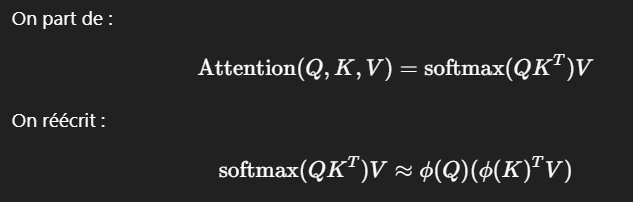

φ = fonction aléatoire positive et orthogonale

On ne calcule plus QK^T

On part de O(n^2) a O(n.d^2) ≈ O(n)

In [11]:
# fonction de projection positive

def phi(x):
    return torch.relu(x) + 1e-6


In [12]:
def linear_attention(Q, K, V):
    Qp = phi(Q) # taille (1, n_tokens, d)
    Kp = phi(K)

    KV = torch.matmul(Kp.transpose(-2, -1), V)
    """
    Kp.T (1, d, n_tokens) V (1, n_tokens, d)
    (1, n_tokens, d) a (1, d, n_tokens)
    KV = (1, d, d)
    """
    Z = torch.matmul(Qp, Kp.sum(dim=1, keepdim=True).transpose(-2, -1))
    # Kp.sum() somme sur tous les tokens, donc on voit tous les tokens sans construire une matrice n_tokens x n_tokens

    output = torch.matmul(Qp, KV) / Z
    return output
print("=== Linear Attention ===")
output = mesure_temps_memoire(linear_attention, Q, K, V)

=== Linear Attention ===
Temps (s) : 0.0368
RAM utilisée (MB) : 1.41


In [13]:
output = linear_attention(Q, K, V)

In [14]:
print(output.shape)

torch.Size([1, 20000, 64])


In [15]:
import psutil
import os
import time

def mesure(func, *args):
    process = psutil.Process(os.getpid())

    mem_before = process.memory_info().rss / (1024 ** 2)
    start = time.time()

    output = func(*args)

    end = time.time()
    mem_after = process.memory_info().rss / (1024 ** 2)

    return {
        "temps_sec": end - start,
        "ram_mb": mem_after - mem_before,
        "taille_sortie": tuple(output.shape),
        "taille_norm": float(output.norm().item())
        # intensite globale des signaux nums produits par le modele
        # c'est la somme des carres des elements
    }


In [16]:
def run_experiment(n_tokens, attention_type="standard", window_size=256):
    d_model = 64
    X = torch.randn(1, n_tokens, d_model)

    Wq = torch.nn.Linear(d_model, d_model)
    Wk = torch.nn.Linear(d_model, d_model)
    Wv = torch.nn.Linear(d_model, d_model)

    Q = Wq(X)
    K = Wk(X)
    V = Wv(X)

    if attention_type == "standard":
        metrics = mesure(self_attention, Q, K, V)

    elif attention_type == "local":
        metrics = mesure(local_self_attention, Q, K, V, window_size)

    elif attention_type == "linear":
        metrics = mesure(linear_attention, Q, K, V)

    metrics["n_tokens"] = n_tokens
    metrics["attention_type"] = attention_type
    if attention_type == "local":
        metrics["window_size"] = window_size

    return metrics


In [17]:
print(run_experiment(20000, "standard"))
print(run_experiment(40000, "local", window_size=256))
print(run_experiment(80000, "linear"))


{'temps_sec': 10.502639770507812, 'ram_mb': 1525.88671875, 'taille_sortie': (1, 20000, 64), 'taille_norm': 82.06514739990234, 'n_tokens': 20000, 'attention_type': 'standard'}
{'temps_sec': 4.308988332748413, 'ram_mb': 74.09375, 'taille_sortie': (1, 40000, 64), 'taille_norm': 126.16556549072266, 'n_tokens': 40000, 'attention_type': 'local', 'window_size': 256}
{'temps_sec': 0.0501093864440918, 'ram_mb': 0.0, 'taille_sortie': (1, 80000, 64), 'taille_norm': 146.75588989257812, 'n_tokens': 80000, 'attention_type': 'linear'}


In [18]:
print(run_experiment(100000, "linear"))

{'temps_sec': 0.05866503715515137, 'ram_mb': 0.0, 'taille_sortie': (1, 100000, 64), 'taille_norm': 185.76522827148438, 'n_tokens': 100000, 'attention_type': 'linear'}


Test

In [19]:
d_model = 64
token_sizes = [2000, 5000, 10000, 20000, 40000, 80000]

times_linear = []
ram_linear = []

for n_tokens in token_sizes:
    X = torch.randn(1, n_tokens, d_model)
    Wq = torch.nn.Linear(d_model, d_model)
    Wk = torch.nn.Linear(d_model, d_model)
    Wv = torch.nn.Linear(d_model, d_model)
    Q = Wq(X)
    K = Wk(X)
    V = Wv(X)

    resultats = mesure(linear_attention, Q, K, V)
    times_linear.append(resultats["temps_sec"])
    ram_linear.append(resultats["ram_mb"])

    """t, m, taille_sortie, taille_norm = measure(linear_attention, Q, K, V)
    times_linear.append(t)
    ram_linear.append(max(m, 0))"""
    print(f"Tokens: {n_tokens} | Temps: {resultats['temps_sec']:.4f}s | RAM: {resultats['ram_mb']:.4f}Mb")

Tokens: 2000 | Temps: 0.0014s | RAM: 0.0000Mb
Tokens: 5000 | Temps: 0.0030s | RAM: 0.0000Mb
Tokens: 10000 | Temps: 0.0062s | RAM: 0.0000Mb
Tokens: 20000 | Temps: 0.0120s | RAM: 0.0000Mb
Tokens: 40000 | Temps: 0.0251s | RAM: 0.0000Mb
Tokens: 80000 | Temps: 0.0502s | RAM: 0.0000Mb


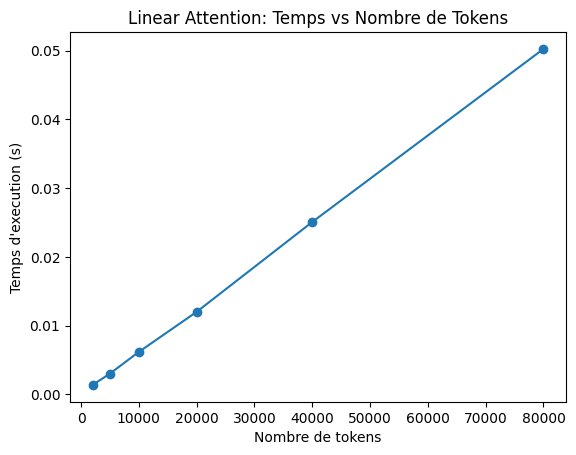

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(token_sizes, times_linear, marker='o')
plt.xlabel("Nombre de tokens")
plt.ylabel("Temps d'execution (s)")
plt.title("Linear Attention: Temps vs Nombre de Tokens")
plt.show()

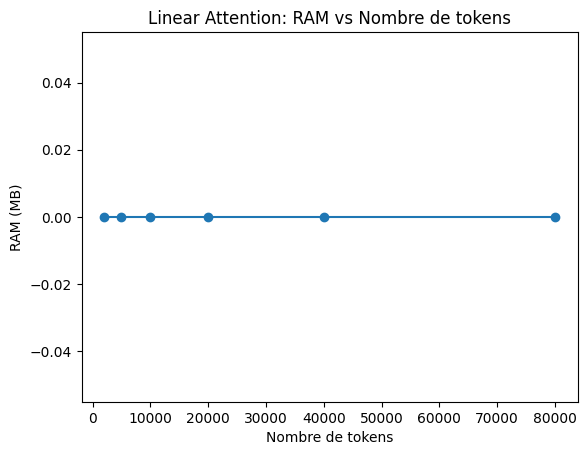

In [21]:
plt.figure()
plt.plot(token_sizes, ram_linear, marker='o')
plt.xlabel("Nombre de tokens")
plt.ylabel("RAM (MB)")
plt.title("Linear Attention: RAM vs Nombre de tokens")
plt.show()

In [22]:
real_tokens = 95842  # close to user's real PDF token count
X_real = torch.randn(1, real_tokens, d_model)
Q_real = Wq(X_real)
K_real = Wk(X_real)
V_real = Wv(X_real)

start = time.time()
out_real = linear_attention(Q_real, K_real, V_real)
elapsed = time.time() - start

print("Applied linear attention to long document")
print("Taille de la sortie:", out_real.shape)
print("Temps (s):", elapsed)

Applied linear attention to long document
Taille de la sortie: torch.Size([1, 95842, 64])
Temps (s): 0.08022499084472656


Ici on ne peut pas mesurer une accuracy, on va donc mesurer la qualite au niveau des representations

Metriques :    


1.   Norme de sortie (stabilité)
2.   Similarité cosinus entre sorties
3.   Sensibilité au contexte lointain



Expérience 1 — Comparer les sorties (cosine similarity)

Principe :

* Même entrée X
* Deux attentions différentes
* On compare les représentations finales token par token



In [23]:
import torch
import torch.nn.functional as F

def compare_outputs(output_local, output_linear):
    # flatten batch
    o1 = output_local.squeeze(0)
    o2 = output_linear.squeeze(0)

    cosine = F.cosine_similarity(o1, o2, dim=-1)
    return {
        "mean_cosine_similarity": cosine.mean().item(),
        "min_similarity": cosine.min().item(),
        "max_similarity": cosine.max().item()
    }


In [24]:
out_local = local_self_attention(Q, K, V, window_size=256)
out_linear = linear_attention(Q, K, V)

compare_outputs(out_local, out_linear)


{'mean_cosine_similarity': 0.9196162223815918,
 'min_similarity': 0.7962706685066223,
 'max_similarity': 0.9756572842597961}

1. mean_cosine_similarity : le modèle optimisé donne un résultat identique à 92 % par rapport au modèle original.
2. min_similarity : sur es phrases les plus compliquées, la ressemblance est descendue à 80 %. Le modèle ne raconte pas n'importe quoi, il reste globalement dans le vrai.
3. max_similarity : la ressemblance est presque parfaite

Resume : On a reussi a rendre le modele beaucoup plus rapide tout en gardant 92 % de sa précision.

Expérience 2 — Sensibilité au contexte lointain

Principe

On modifie un token très éloigné dans la séquence
→ On regarde si un token au début change

Cas 1 : Local attention
* Fenêtre limitée → pas d’impact

Cas 2 : Linear attention

* Mélange global → impact visible

In [33]:
# Fonctions de passage (Wrappers) pour isoler les arguments
def wrap_local(Q, K, V, **kwargs):
    # On ne passe que window_size à l'attention locale
    w = kwargs.get('window_size', 128)
    return local_self_attention(Q, K, V, window_size=w)

def wrap_linear(Q, K, V, **kwargs):
    # L'attention linéaire n'a pas besoin de window_size ou feature_map ici
    # si elles sont déjà intégrées dans sa logique interne
    return linear_attention(Q, K, V)

def perturbation_test(X, attention_fn, **kwargs):
    X1 = X.clone()
    X2 = X.clone()

    # Perturbation forte sur le DERNIER token
    X2[:, -1, :] += 10.0

    # On simule Q, K, V (auto-attention)
    out1 = attention_fn(X1, X1, X1, **kwargs)
    out2 = attention_fn(X2, X2, X2, **kwargs)

    # On mesure l'impact sur le PREMIER token (index 0)
    diff = torch.norm(out1[:, 0, :] - out2[:, 0, :])
    return diff.item()

In [34]:
tailles = [128, 256, 512, 1024]
res_loc = []
res_lin = []

for n in tailles:
    X = torch.randn(1, n, d_model)

    # Test local : on s'attend à ce que diff devienne 0 dès que n > window_size
    d_l = perturbation_test(X, wrap_local, window_size=128)
    res_loc.append(d_l)

    # Test linéaire : on s'attend à une valeur > 0 car le mélange est global
    d_i = perturbation_test(X, wrap_linear)
    res_lin.append(d_i)

    print(f"Taille {n} | Local: {d_l:.2e} | Linéaire: {d_i:.2e}")

Taille 128 | Local: 4.58e+01 | Linéaire: 1.29e+01
Taille 256 | Local: 0.00e+00 | Linéaire: 6.86e+00
Taille 512 | Local: 0.00e+00 | Linéaire: 3.73e+00
Taille 1024 | Local: 0.00e+00 | Linéaire: 1.90e+00


Résultat attendu :

* Local attention → différence ≈ 0

* Linear attention → différence > 0

L’attention locale ignore les dépendances longues, tandis que l’attention linéaire conserve une influence globale.



---



| Critère             | Local Attention | Linear Attention |
| ------------------- | --------------- | ---------------- |
| Dépendances locales | ✅ excellentes   | ⚠️ moyennes      |
| Dépendances longues | ❌ absentes      | ✅ présentes      |
| Qualité globale     | ⚠️ fragmentée   | ✅ cohérente      |
| Scalabilité         | ⚠️ limitée      | ✅ excellente     |




---



---



| Méthode                        | Qualité / fidélité softmax               | Stabilité                         | Complexité mémoire / temps    | Notes pratiques                                                   |
| ------------------------------ | ---------------------------------------- | --------------------------------- | ----------------------------- | ----------------------------------------------------------------- |
| **Linear Attention simple**    | Moyenne → approxime global attention     | Moyenne, peut introduire du bruit | O(N·d) mémoire, O(N·d²) temps | Très rapide, simple, mais peut perdre des dépendances importantes |
| **Performer (FAVOR+)**         | Haute → approxime très bien softmax réel | Bonne                             | O(N·d) mémoire, O(N·d²) temps | Près du résultat exact de l’attention standard, scalable          |
| **Kernel Attention générique** | Variable → dépend du kernel choisi       | Variable                          | O(N·d) mémoire                | Très flexible, mais qualité dépend du kernel choisi               |


## Importation des bibliotheuqes

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import math
from dataclasses import dataclass
from typing import Optional, Tuple, List
from transformers import (
    BartTokenizer, BartForConditionalGeneration,
    LEDTokenizer, LEDForConditionalGeneration,
    AutoTokenizer, AutoModelForSeq2SeqLM
)
import warnings
warnings.filterwarnings('ignore')

Transformer standard

In [ ]:
@dataclass

class Configurations:
  vocab_size: int = 50000
  d_model: int = 512
  nbre_tete: int = 8
  nbre_couche: int = 6
  #n_encoder_layers: int = 6
  #n_decoder_layers: int = 6
  d_ff: int = 2048
  max_seq_length: int = 512
  dropout: float = 0.1
  #pad_token_id: int = 0

Attention Multi Tete

In [ ]:
class AttentionMultiTetes(nn.Module):
    def __init__(self, d_modele, nb_tetes):
        super(AttentionMultiTetes, self).__init__()
        # S'assurer que la dimension du modèle (d_modele) est divisible par le nombre de têtes
        assert d_modele % nb_tetes == 0, "d_modele doit être divisible par nb_tetes"

        # Initialisation des dimensions
        self.d_modele = d_modele # Dimension du modèle
        self.nb_tetes = nb_tetes # Nombre de têtes d'attention
        self.d_k = d_modele // nb_tetes # Dimension des clés, requêtes et valeurs de chaque tête

        # Couches linéaires pour la transformation des entrées
        self.W_q = nn.Linear(d_modele, d_modele) # Transformation des Requêtes (Query)
        self.W_k = nn.Linear(d_modele, d_modele) # Transformation des Clés (Key)
        self.W_v = nn.Linear(d_modele, d_modele) # Transformation des Valeurs (Value)
        self.W_o = nn.Linear(d_modele, d_modele) # Transformation de Sortie (Output)

    def attention_produit_scalaire_normalisee(self, Q, K, V, masque=None):
        # Calcul des scores d'attention
        scores_attn = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Appliquer le masque si fourni (utile pour ignorer le rembourrage/padding)
        if masque is not None:
            scores_attn = scores_attn.masked_fill(masque == 0, -1e9)

        # Application du Softmax pour obtenir les probabilités d'attention
        probs_attn = torch.softmax(scores_attn, dim=-1)

        # Multiplier par les valeurs pour obtenir la sortie finale
        sortie = torch.matmul(probs_attn, V)
        return sortie

    def separer_tetes(self, x):
        # Redimensionner l'entrée pour avoir plusieurs têtes d'attention
        taille_batch, long_seq, d_modele = x.size()
        return x.view(taille_batch, long_seq, self.nb_tetes, self.d_k).transpose(1, 2)

    def combiner_tetes(self, x):
        # Combiner les têtes multiples pour revenir à la forme originale
        taille_batch, _, long_seq, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(taille_batch, long_seq, self.d_modele)

    def forward(self, Q, K, V, masque=None):
        # Appliquer les transformations linéaires et séparer les têtes
        Q = self.separer_tetes(self.W_q(Q))
        K = self.separer_tetes(self.W_k(K))
        V = self.separer_tetes(self.W_v(V))

        # Effectuer l'attention par produit scalaire normalisée
        sortie_attn = self.attention_produit_scalaire_normalisee(Q, K, V, masque)

        # Combiner les têtes et appliquer la transformation de sortie finale
        sortie = self.W_o(self.combiner_tetes(sortie_attn))
        return sortie

In [ ]:
class ReseauNeuronesPositionnel(nn.Module):
    def __init__(self, d_modele, d_ff):
        super(ReseauNeuronesPositionnel, self).__init__()
        # Première couche linéaire (expansion de la dimension)
        self.fc1 = nn.Linear(d_modele, d_ff)
        # Seconde couche linéaire (retour à la dimension originale du modèle)
        self.fc2 = nn.Linear(d_ff, d_modele)
        # Fonction d'activation non-linéaire
        self.relu = nn.ReLU()

    def forward(self, x):
        # Passage dans la première couche, activation ReLU, puis seconde couche
        return self.fc2(self.relu(self.fc1(x)))

In [ ]:
class EncodagePositionnel(nn.Module):
    def __init__(self, d_modele, long_max_seq):
        super(EncodagePositionnel, self).__init__()

        # Création d'une matrice d'encodage positionnel (pe) remplie de zéros
        pe = torch.zeros(long_max_seq, d_modele)

        # Création d'un vecteur de positions (0, 1, 2, ..., long_max_seq)
        position = torch.arange(0, long_max_seq, dtype=torch.float).unsqueeze(1)

        # Calcul du terme de division pour les fréquences sinus et cosinus
        terme_div = torch.exp(torch.arange(0, d_modele, 2).float() * -(math.log(10000.0) / d_modele))

        # Application de la fonction sinus aux indices pairs (0, 2, 4...)
        pe[:, 0::2] = torch.sin(position * terme_div)

        # Application de la fonction cosinus aux indices impairs (1, 3, 5...)
        pe[:, 1::2] = torch.cos(position * terme_div)

        # Enregistrer 'pe' comme un buffer (ne sera pas considéré comme un paramètre entraînable)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # Ajoute l'encodage positionnel aux plongements (embeddings) d'entrée
        return x + self.pe[:, :x.size(1)]

In [ ]:
class CoucheEncodeur(nn.Module):
    def __init__(self, d_modele, nb_tetes, d_ff, dropout):
        super(CoucheEncodeur, self).__init__()
        # Auto-attention multi-têtes
        self.auto_attn = AttentionMultiTetes(d_modele, nb_tetes) ### ici
        # Réseau de neurones positionnel (Feed-Forward)
        self.reseau_positionnel = ReseauNeuronesPositionnel(d_modele, d_ff)
        # Couches de normalisation
        self.norm1 = nn.LayerNorm(d_modele)
        self.norm2 = nn.LayerNorm(d_modele)
        # Couche de dropout pour la régularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, masque):
        # Étape 1 : Auto-attention et connexion résiduelle suivie d'une normalisation
        sortie_attn = self.auto_attn(x, x, x, masque)
        x = self.norm1(x + self.dropout(sortie_attn))

        # Étape 2 : Réseau Feed-Forward et connexion résiduelle suivie d'une normalisation
        sortie_ff = self.reseau_positionnel(x)
        x = self.norm2(x + self.dropout(sortie_ff))

        return x

In [ ]:
class CoucheDecodeur(nn.Module):
    def __init__(self, d_modele, nb_tetes, d_ff, dropout):
        super(CoucheDecodeur, self).__init__()
        # Auto-attention pour les tokens de la cible (déjà générés)
        self.auto_attn = AttentionMultiTetes(d_modele, nb_tetes)
        # Attention croisée pour regarder la sortie de l'encodeur
        self.attn_croisee = AttentionMultiTetes(d_modele, nb_tetes)
        # Réseau de neurones positionnel (Feed-Forward)
        self.reseau_positionnel = ReseauNeuronesPositionnel(d_modele, d_ff)

        # Couches de normalisation
        self.norm1 = nn.LayerNorm(d_modele)
        self.norm2 = nn.LayerNorm(d_modele)
        self.norm3 = nn.LayerNorm(d_modele)
        # Couche de dropout pour la régularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sortie_encodeur, masque_src, masque_tgt):
        # Étape 1 : Auto-attention sur la cible avec masque (pour ne pas voir le futur)
        sortie_auto_attn = self.auto_attn(x, x, x, masque_tgt)
        x = self.norm1(x + self.dropout(sortie_auto_attn))

        # Étape 2 : Attention croisée (Requête vient du décodeur, Clé/Valeur de l'encodeur)
        sortie_attn_croisee = self.attn_croisee(x, sortie_encodeur, sortie_encodeur, masque_src)
        x = self.norm2(x + self.dropout(sortie_attn_croisee))

        # Étape 3 : Réseau Feed-Forward
        sortie_ff = self.reseau_positionnel(x)
        x = self.norm3(x + self.dropout(sortie_ff))

        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, taille_vocab_src, taille_vocab_tgt, d_modele, nb_tetes, nb_couches, d_ff, long_max_seq, dropout):
        super(Transformer, self).__init__()
        # Couches de plongement (embeddings) pour la source et la cible
        self.plongement_encodeur = nn.Embedding(taille_vocab_src, d_modele)
        self.plongement_decodeur = nn.Embedding(taille_vocab_tgt, d_modele)
        # Module d'encodage positionnel
        self.encodage_positionnel = EncodagePositionnel(d_modele, long_max_seq)

        # Listes de couches pour l'encodeur et le décodeur
        self.couches_encodeur = nn.ModuleList([CoucheEncodeur(d_modele, nb_tetes, d_ff, dropout) for _ in range(nb_couches)])
        self.couches_decodeur = nn.ModuleList([CoucheDecodeur(d_modele, nb_tetes, d_ff, dropout) for _ in range(nb_couches)])

        # Couche linéaire finale pour la prédiction des mots
        self.fc = nn.Linear(d_modele, taille_vocab_tgt)
        self.dropout = nn.Dropout(dropout)

    def generer_masque(self, src, tgt):
        # Masque pour ignorer les jetons de rembourrage (padding) dans la source
        masque_src = (src != 0).unsqueeze(1).unsqueeze(2)
        # Masque pour ignorer le rembourrage dans la cible
        masque_tgt = (tgt != 0).unsqueeze(1).unsqueeze(3)

        # Masque triangulaire pour empêcher le décodeur de regarder les mots futurs
        long_seq = tgt.size(1)
        masque_causal = (1 - torch.triu(torch.ones(1, long_seq, long_seq), diagonal=1)).bool()
        masque_tgt = masque_tgt & masque_causal

        return masque_src, masque_tgt

    def forward(self, src, tgt):
        # 1. Génération des masques
        masque_src, masque_tgt = self.generer_masque(src, tgt)

        # 2. Préparation des entrées (Embedding + Encodage Positionnel)
        src_embedded = self.dropout(self.encodage_positionnel(self.plongement_encodeur(src)))
        tgt_embedded = self.dropout(self.encodage_positionnel(self.plongement_decodeur(tgt)))

        # 3. Passage à travers les couches de l'encodeur
        sortie_encodeur = src_embedded
        for couche_enc in self.couches_encodeur:
            sortie_encodeur = couche_enc(sortie_encodeur, masque_src)

        # 4. Passage à travers les couches du décodeur
        sortie_decodeur = tgt_embedded
        for couche_dec in self.couches_decodeur:
            sortie_decodeur = couche_dec(sortie_decodeur, sortie_encodeur, masque_src, masque_tgt)

        # 5. Projection finale vers le vocabulaire de sortie
        output = self.fc(sortie_decodeur)
        return output

In [ ]:
# Configuration des hyperparamètres
taille_vocab_src = 50000
taille_vocab_tgt = 5000
d_modele = 512
nb_tetes = 8
nb_couches = 6
d_ff = 2048
long_max_seq = 5000  # Augmenté pour tester les limites du modèle
dropout = 0.1

# Initialisation du modèle avec les noms de variables traduits
transformer = Transformer(
    taille_vocab_src,
    taille_vocab_tgt,
    d_modele,
    nb_tetes,
    nb_couches,
    d_ff,
    long_max_seq,
    dropout
)

# Génération de données d'exemple aléatoires
# src_donnees : (taille_batch, long_sequence)
taille_batch = 64
src_donnees = torch.randint(1, taille_vocab_src, (taille_batch, long_max_seq))
tgt_donnees = torch.randint(1, taille_vocab_tgt, (taille_batch, long_max_seq))

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimiser = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
transformer.train()

for epoch in range(100):
    # on met les grad a zero
    optimiser.zero_grad()

    # tgt_donnees[:, :-1] signifie qu'on donne tout sauf le dernier mot
    sortie = transformer(src_donnees, tgt_donnees[:, :-1])

    # view(-1) permet d'aplatir les tenseurs pour le calcul de l'entropie croisée
    perte = criterion(sortie.contiguous().view(-1, taille_vocab_tgt),
                   tgt_donnees[:, 1:].contiguous().view(-1))

    perte.backward()
    optimiser.step()
    print(f"Époque: {epoch+1}, Perte: {perte.item():.4f}")

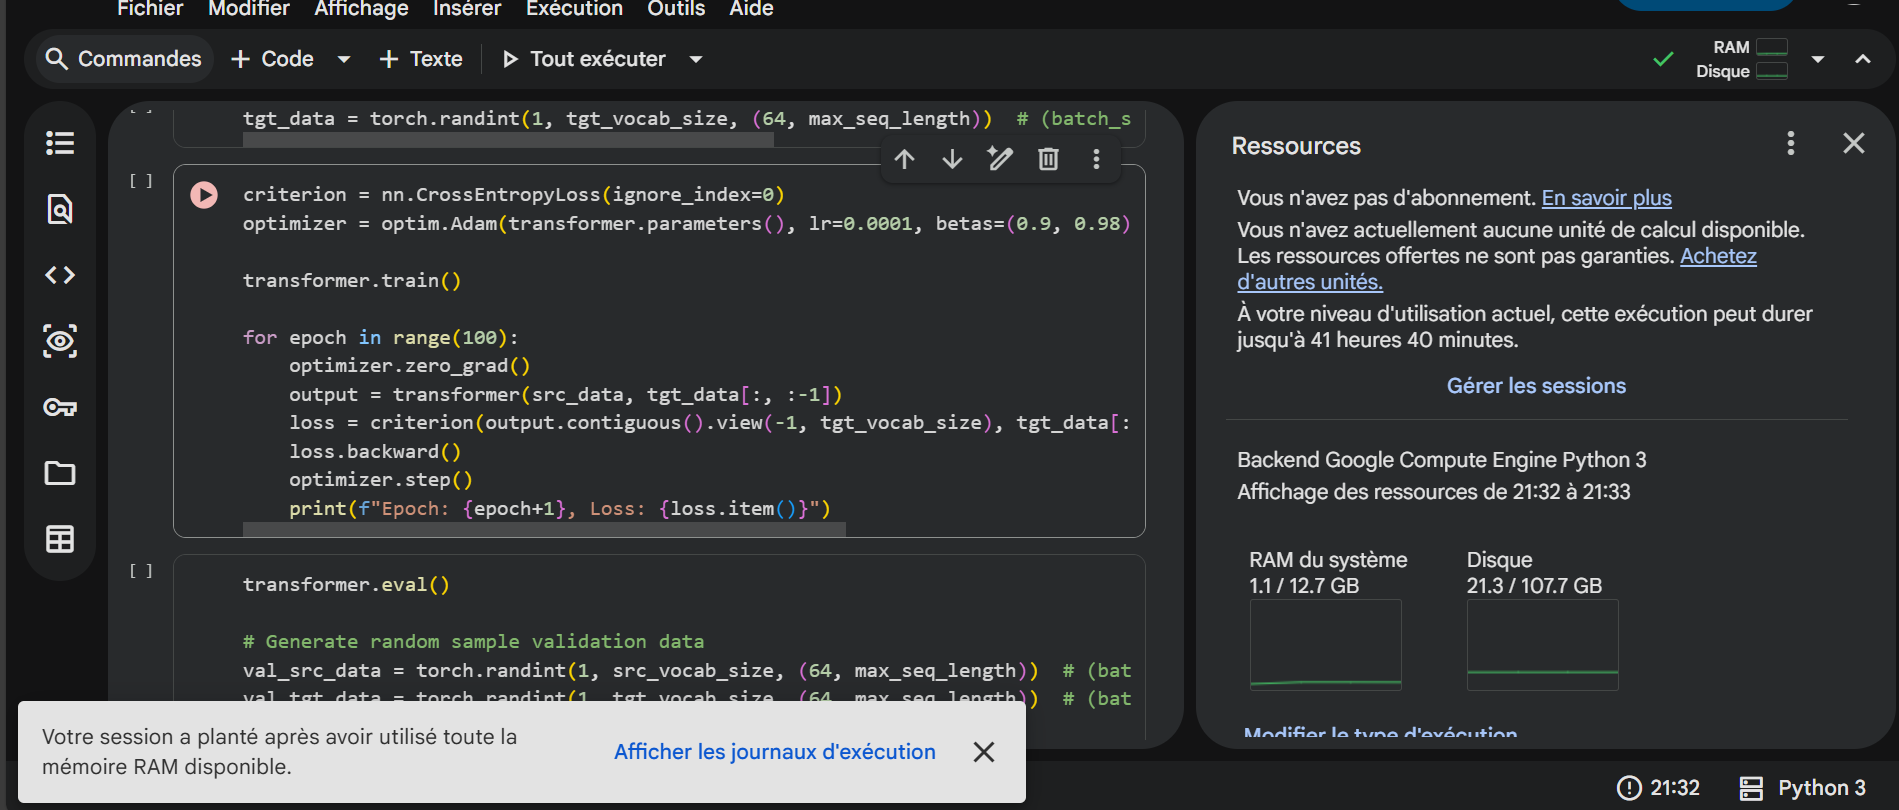

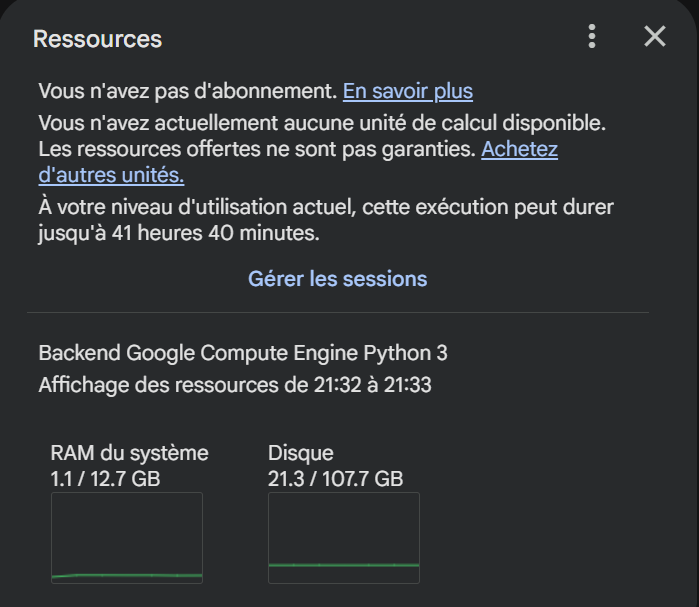

In [ ]:
transformer.eval()

# Génération de données de validation aléatoires
# val_src_donnees : données sources de validation
# val_tgt_donnees : données cibles de validation
taille_batch = 64
val_src_donnees = torch.randint(1, taille_vocab_src, (taille_batch, long_max_seq))
val_tgt_donnees = torch.randint(1, taille_vocab_tgt, (taille_batch, long_max_seq))

with torch.no_grad():
    # Passage en avant sur les données de validation
    val_sortie = transformer(val_src_donnees, val_tgt_donnees[:, :-1])

    # Calcul de la perte de validation
    perte_val = criterion(val_sortie.contiguous().view(-1, taille_vocab_tgt),
                        val_tgt_donnees[:, 1:].contiguous().view(-1))

    print(f"Perte de Validation : {perte_val.item():.4f}")

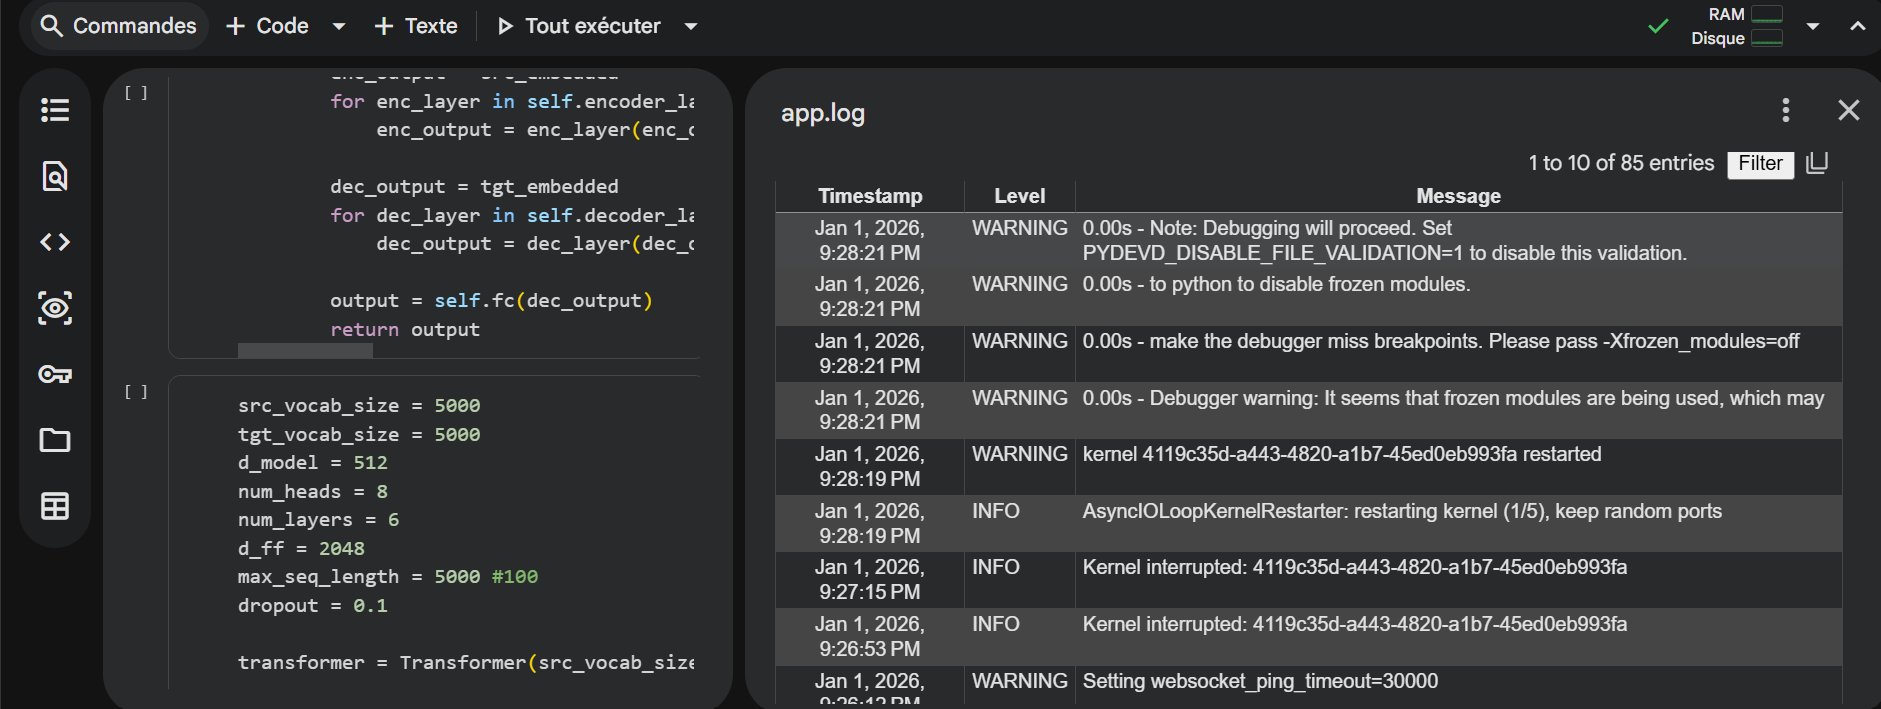

Solution 1 : Sparse Attention
Un token n'observe que ses voisins.
O(n.w)

Longformer

BigBird

In [ ]:
"""# attention locale
for i in range(n):
    start = max(0, i - w)
    end = min(n, i + w)
    attend(Q[i], K[start:end], V[start:end])
"""

Solution 2 : Linearisation de l'attention
O(n)

Performer

Linear Transformer

softmax(QK^T)V≈ϕ(Q)(ϕ(K)^(T) V)

In [ ]:
"""K_prime = phi(K)
Q_prime = phi(Q)

KV = torch.matmul(K_prime.transpose(-2,-1), V)
output = torch.matmul(Q_prime, KV)
"""